# COVID-19 Tracker

## Basic code and data

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
from pandas_datareader import wb
# plt.style.use('dark_background')

# # solves issue accessing WB databse
# # https://github.com/pydata/pandas-datareader/issues/493
import requests
session = requests.Session()
session.verify = False

%config InlineBackend.figure_format = 'svg'

In [2]:
# This gets the data from John Hopkins university -- it is online in github

header = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
global_confirmed = pd.read_csv(header + "time_series_covid19_confirmed_global.csv")
global_deaths = pd.read_csv(header + "time_series_covid19_deaths_global.csv")
us_deaths = pd.read_csv(header + "time_series_covid19_deaths_US.csv")
us_confirmed = pd.read_csv(header + "time_series_covid19_confirmed_US.csv")

In [3]:
START_DATE = pd.to_datetime('Feb 15, 2020')

# converting JHU names to World Bank names
WB_ISO2_CODES = {
    "Korea, South": "KR"
}

COUNTRIES = {}
for i in global_confirmed["Country/Region"]:
    COUNTRIES[i] = None

In [4]:

def to_timeseries(s):
    s.index = pd.DatetimeIndex(s.index)
    return s 
    
def diff_clip(s):
    return s.diff().clip(lower=0.0, upper=None) # clip out negative observations
    
# Some functions to plot the data by county, state and country

def do_diff_plots(ts1, ts2, title1, title2):
    ts1 = diff_clip(to_timeseries(ts1))
    ts2 = diff_clip(to_timeseries(ts2))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,4]) 
    for ax, titl, ts in zip(axes, [title1, title2], [ts1, ts2]):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ts.plot.area(ax=ax, title=titl, alpha=.7)
        ts.rolling(7, center=True).mean().plot(ax=ax, color="black")
        ax.set_xlim(left=START_DATE)
    return fig    

def plot_county(county, state):
    ts1 = us_deaths[(us_deaths["Province_State"] == state) & (us_deaths["Admin2"] == county) ].iloc[:, 12:].sum()
    ts2 = us_confirmed[(us_confirmed["Province_State"] == state) & (us_confirmed["Admin2"] == county) ].iloc[:, 11:].sum()
    do_diff_plots(ts1, ts2, county + ", " + state + ", Deaths", county + ", " + state + ", Confirmed")
        
def plot_state(state):
    ts1 = us_deaths[(us_deaths["Province_State"] == state)].iloc[:, 12:].sum()
    ts2 = us_confirmed[(us_confirmed["Province_State"] == state)].iloc[:, 11:].sum()
    do_diff_plots(ts1, ts2, state + ", Deaths", state + ", Confirmed",)
    
def plot_global(country):
    if not(country in COUNTRIES):
        print("Country ", country, "not in dataset. Check COUNTRIES dictionary.")
    else:
        ts1 = global_deaths[global_deaths["Country/Region"] == country].iloc[:, 6:].sum()
        ts2 = global_confirmed[global_confirmed["Country/Region"] == country].iloc[:, 6:].sum()
        do_diff_plots(ts1, ts2, country + ", Deaths", country + ", Confirmed")
    
def plot_county_pc(county, state):
    population = us_deaths[(us_deaths["Province_State"] == state) & (us_deaths["Admin2"] == county)].loc[:, "Population"].sum()
    ts1 = us_deaths[(us_deaths["Province_State"] == state) & (us_deaths["Admin2"] == county) ].iloc[:, 12:].sum()
    ts2 = us_confirmed[(us_confirmed["Province_State"] == state) & (us_confirmed["Admin2"] == county) ].iloc[:, 11:].sum()
    ts1 = ts1 * 1000000 / population
    ts2 = ts2 * 1000000 / population
    do_diff_plots(ts1, ts2, county + ", " + state + ", Deaths \n per million", county + ", " + state + ", Confirmed \n per million")
        
def plot_state_pc(state):
    # getting the state population from the table
    population = us_deaths[(us_deaths["Province_State"] == state)].loc[:, "Population"].sum() 
    ts1 = us_deaths[(us_deaths["Province_State"] == state)].iloc[:, 12:].sum()
    ts2 = us_confirmed[(us_confirmed["Province_State"] == state)].iloc[:, 11:].sum()
    ts1 = ts1 * 1000000 / population
    ts2 = ts2 * 1000000 / population
    do_diff_plots(ts1, ts2, state + ", Deaths \n per million", state + ", Confirmed \n per million")

def plot_global_pc(country):
    if not(country in COUNTRIES):
        print("Country ", country, " not in dataset. Check COUNTRIES dictionary.")
    else:
        try:
            if country in WB_ISO2_CODES:
                iso2 = WB_ISO2_CODES[country]
            else:
                iso2 = wb.get_countries(session=session).query('name == "' + country + '"').iso2c.values[0]
        except:
            print("Country ", country, ": No matching World Bank ISO code available. Update WB_ISO2_CODES.")
        else:
            population = wb.download(indicator="SP.POP.TOTL", country=iso2, 
                    start=2010, end=2020, session=session).dropna().values[0, 0]
            ts1 = global_deaths[global_deaths["Country/Region"] == country].iloc[:, 6:].sum()
            ts2 = global_confirmed[global_confirmed["Country/Region"] == country].iloc[:, 6:].sum()
            ts1 = ts1 * 1000000 / population
            ts2 = ts2 * 1000000 / population
            do_diff_plots(ts1, ts2, country + ", Deaths \n per million", country + ", Confirmed \n per million")

def plot_global_list(ls):
    for country in ls:
        plot_global(country);

def plot_global_pc_list(ls):
    for country in ls:
        plot_global_pc(country);

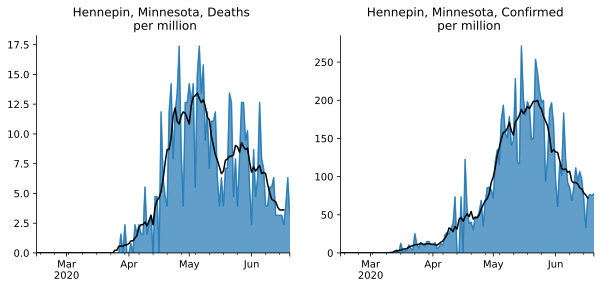

In [5]:
plot_county_pc("Hennepin", "Minnesota")

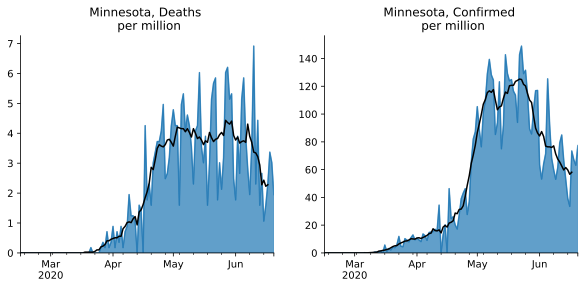

In [6]:
plot_state_pc("Minnesota")

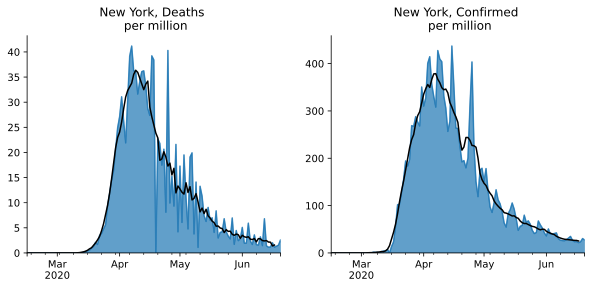

In [7]:
plot_state_pc("New York")

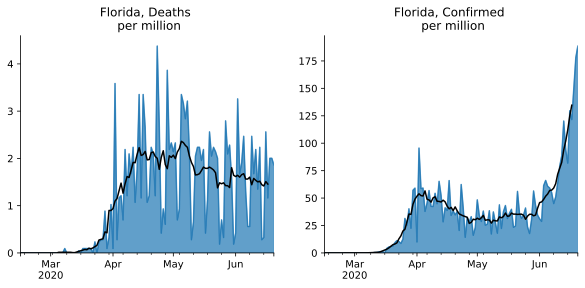

In [8]:
plot_state_pc("Florida")

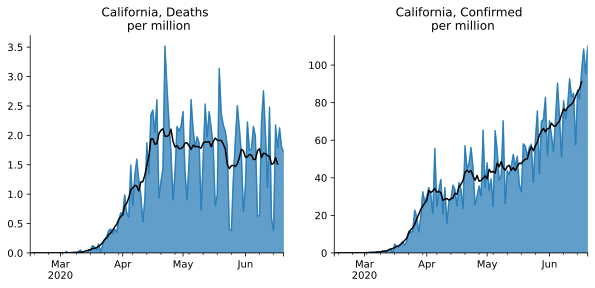

In [9]:
plot_state_pc("California")

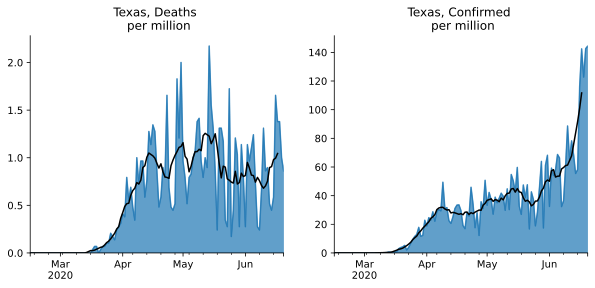

In [10]:
plot_state_pc("Texas")

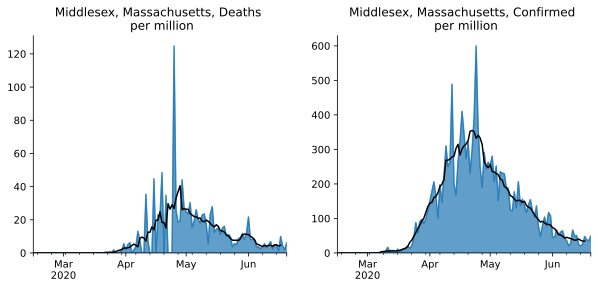

In [11]:
plot_county_pc("Middlesex", "Massachusetts")

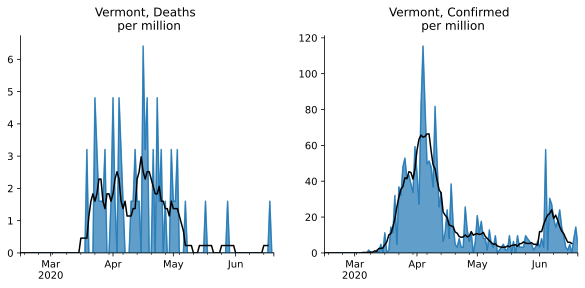

In [12]:
plot_state_pc("Vermont")

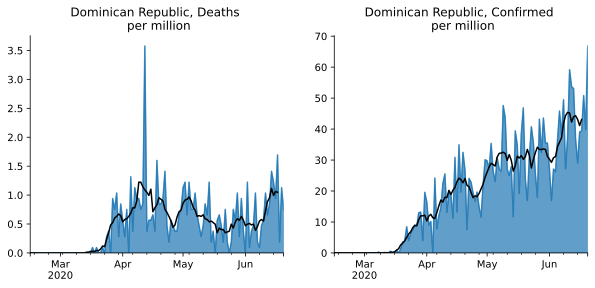

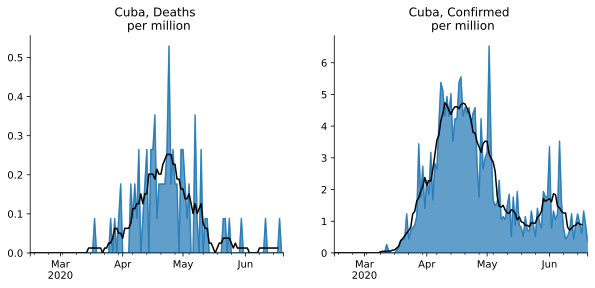

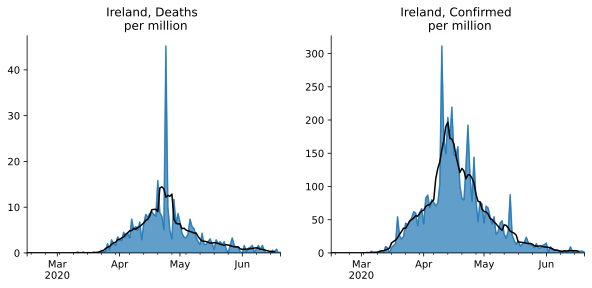

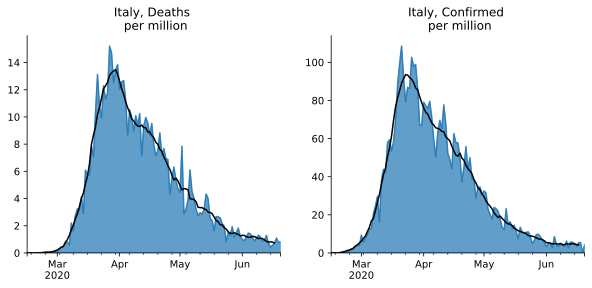

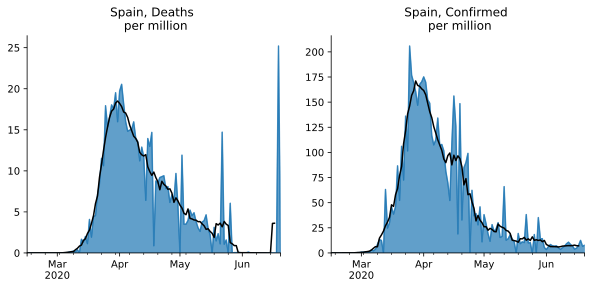

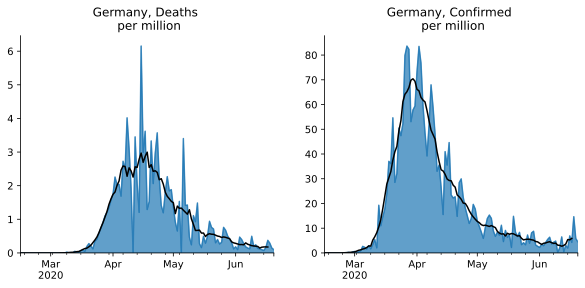

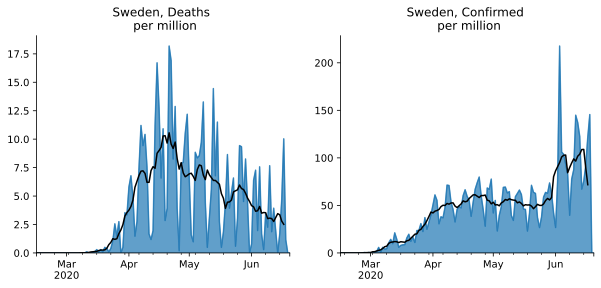

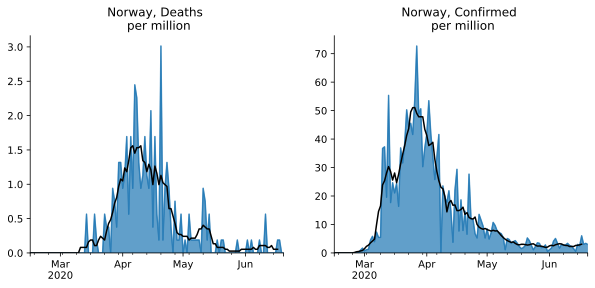

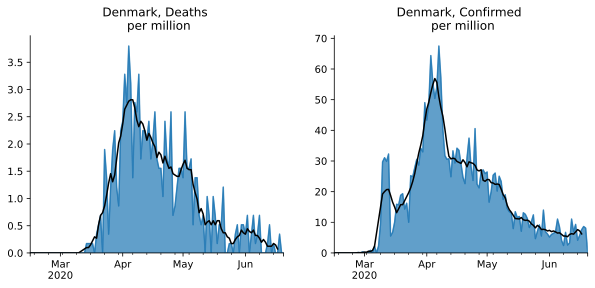

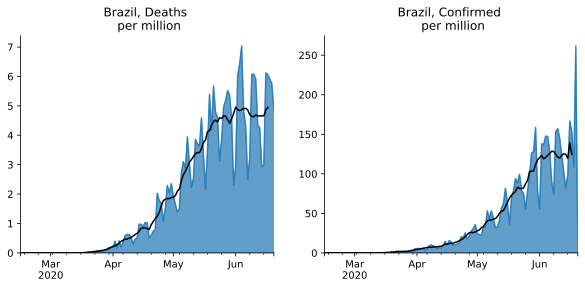

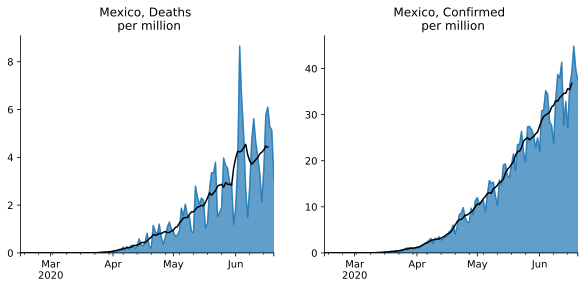

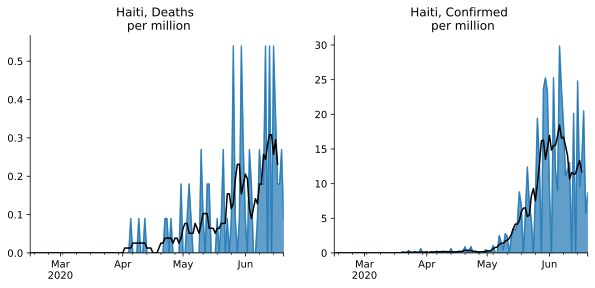

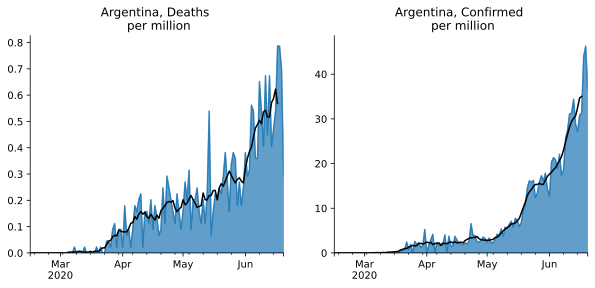

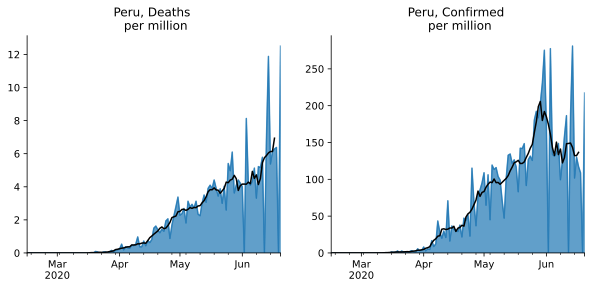

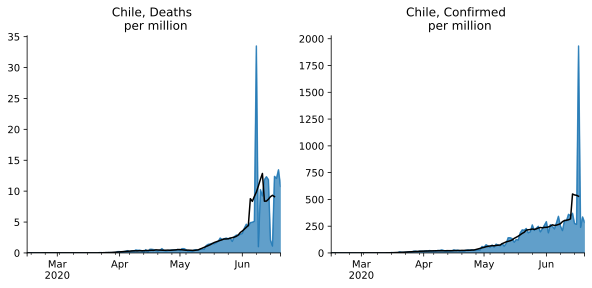

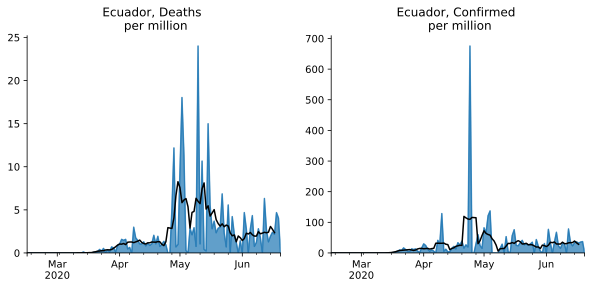

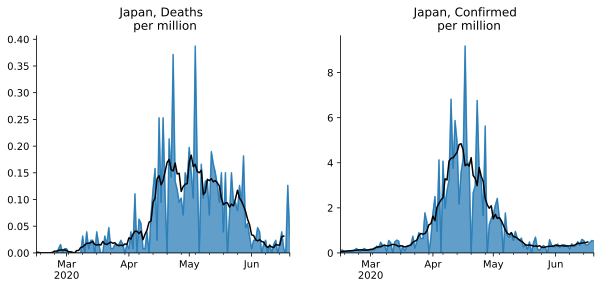

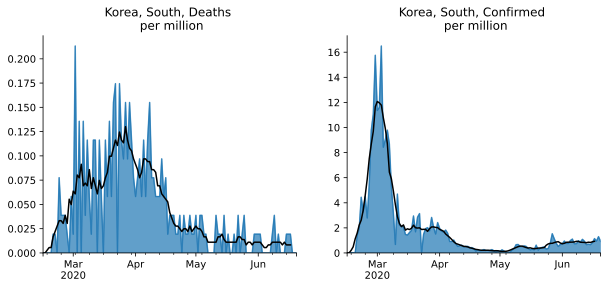

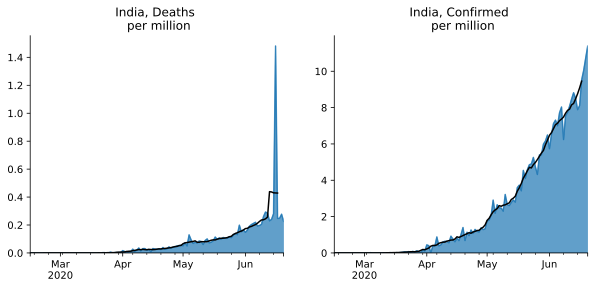

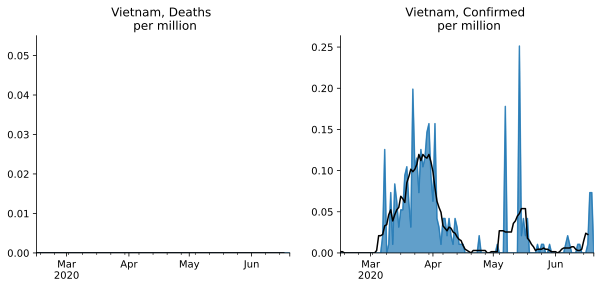

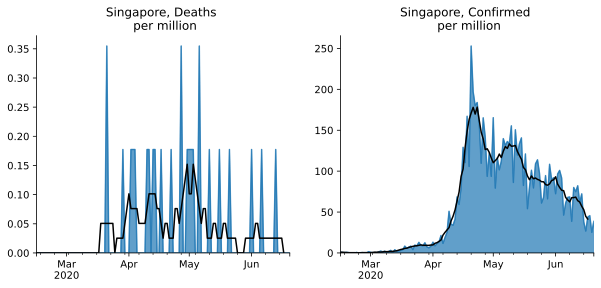

In [13]:
plot_global_pc_list(["Dominican Republic", "Cuba", "Ireland", "Italy", "Spain", "Germany", "Sweden", "Norway", "Denmark", "Brazil", "Mexico", "Haiti", "Argentina", "Peru", "Chile", "Ecuador", "Japan", "Korea, South", "India", "Vietnam", "Singapore"])